# Classification

Matěj Kopecký

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations, product
from skimage import color
import cv2
from utils import Segmentation
from PIL import Image
from random import Random
from copy import deepcopy
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize

In [146]:
def split_image(img, size=128):
    if img.shape[0] % size != 0 or img.shape[1] % size != 0:
        raise ValueError(f"Image size is wrong for piece size {size}x{size}.")
    
    piece_vert = img.shape[0]//size
    piece_hori = img.shape[1]//size

    pieces = []
    for i in range(piece_vert):
        for j in range(piece_hori):
            new_piece = img[i*size:(i+1)*size, j*size:(j+1)*size,:]
            pieces.append(new_piece)

    return pieces

In [147]:
segmenter = Segmentation()
img0 = segmenter.load_input_image_("00_00", folder="train2_solutions", flag='solution')
img1 = segmenter.load_input_image_("00_01", folder="train2_solutions", flag='solution')
img2 = segmenter.load_input_image_("00_02", folder="train2_solutions", flag='solution')
out0 = Image.open("data_project/train2_solutions/outlier_00_00.png")
outliers = [np.asarray(out0)]

pieces0 = split_image(img0)
pieces1 = split_image(img1)
pieces2 = split_image(img2)
#Segmentation.plot_images(pieces2)

all_pieces = []
all_pieces.extend(outliers)
all_pieces.extend(pieces0)
all_pieces.extend(pieces1)
all_pieces.extend(pieces2)

In [148]:
"""img0 = segmenter.load_input_image_("01_00", folder="train2_solutions", flag='solution')
img1 = segmenter.load_input_image_("01_01", folder="train2_solutions", flag='solution')
#img2 = segmenter.load_input_image_("00_02", folder="train2_solutions", flag='solution')
out0 = np.asarray(Image.open("data_project/train2_solutions/outlier_01_00.png"))
out1 = np.asarray(Image.open("data_project/train2_solutions/outlier_01_01.png"))
out2 = np.asarray(Image.open("data_project/train2_solutions/outlier_01_02.png"))


pieces0 = split_image(img0)
pieces1 = split_image(img1)
#pieces2 = split_image(img2)

all_pieces = []
outliers = [out0, out1, out2]
all_pieces.extend(outliers)
all_pieces.extend(pieces0)
all_pieces.extend(pieces1)
#all_pieces.extend(pieces2)
Segmentation.plot_images(all_pieces)"""

'img0 = segmenter.load_input_image_("01_00", folder="train2_solutions", flag=\'solution\')\nimg1 = segmenter.load_input_image_("01_01", folder="train2_solutions", flag=\'solution\')\n#img2 = segmenter.load_input_image_("00_02", folder="train2_solutions", flag=\'solution\')\nout0 = np.asarray(Image.open("data_project/train2_solutions/outlier_01_00.png"))\nout1 = np.asarray(Image.open("data_project/train2_solutions/outlier_01_01.png"))\nout2 = np.asarray(Image.open("data_project/train2_solutions/outlier_01_02.png"))\n\n\npieces0 = split_image(img0)\npieces1 = split_image(img1)\n#pieces2 = split_image(img2)\n\nall_pieces = []\noutliers = [out0, out1, out2]\nall_pieces.extend(outliers)\nall_pieces.extend(pieces0)\nall_pieces.extend(pieces1)\n#all_pieces.extend(pieces2)\nSegmentation.plot_images(all_pieces)'

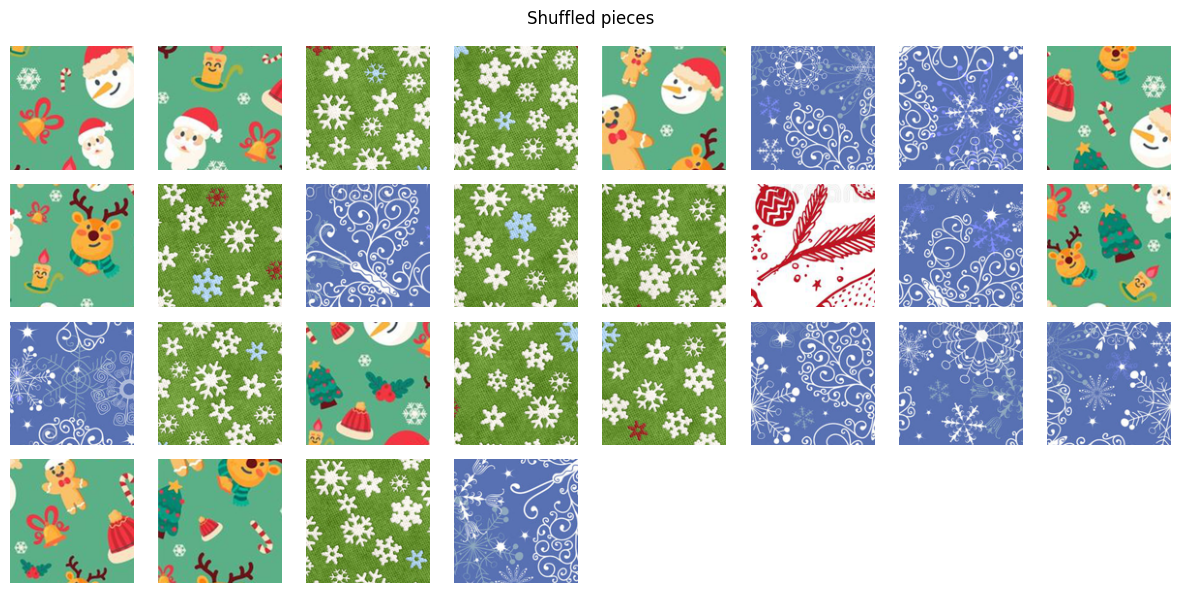

In [149]:
seed = 1
shuffled_pieces = deepcopy(all_pieces)
Random(seed).shuffle(shuffled_pieces)
Segmentation.plot_images(shuffled_pieces, title="Shuffled pieces")

In [150]:
labels0 = [0 for i in range(len(pieces0))]
labels1 = [1 for i in range(len(pieces1))]
labels2 = [2 for i in range(len(pieces2))]
out_labels = [-1 for i in range(len(outliers))]

labels = []
labels.extend(out_labels)
labels.extend(labels0)
labels.extend(labels1)
labels.extend(labels2)

print("Labels")
print(labels)

shuffled_labels = deepcopy(labels)
Random(seed).shuffle(shuffled_labels)
print("Shuffled labels")
print(shuffled_labels)

len(labels) == len(all_pieces)


Labels
[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Shuffled labels
[2, 2, 1, 1, 2, 0, 0, 2, 2, 1, 0, 1, 1, -1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 0, 2, 2, 1, 0]


True

In [151]:
clabels0 = ["b" for i in range(len(pieces0))]
clabels1 = ["g" for i in range(len(pieces1))]
clabels2 = ["r" for i in range(len(pieces1))]
clabels = ["y"]

clabels.extend(clabels0)
clabels.extend(clabels1)
clabels.extend(clabels2)

cshuffled_labels = deepcopy(clabels)
Random(seed).shuffle(cshuffled_labels)
print(cshuffled_labels)


['r', 'r', 'g', 'g', 'r', 'b', 'b', 'r', 'r', 'g', 'b', 'g', 'g', 'y', 'b', 'r', 'b', 'g', 'r', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'g', 'b']


In [152]:
num_features = 6

def extract_feature(img:np.ndarray) -> np.ndarray:
    features = np.zeros(num_features)

    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]

    # mean
    red_mean = np.mean(red)
    green_mean = np.mean(green)
    blue_mean = np.mean(blue)

    features[0] = red_mean
    features[1] = green_mean
    features[2] = blue_mean

    # variance
    features[3] = np.var(red)
    features[4] = np.var(green)
    features[5] = np.var(blue)


    return features

In [153]:
all_features = np.zeros((len(all_pieces), num_features))
for i in range(len(all_pieces)):
    all_features[i,:] = extract_feature(all_pieces[i])
    
print(all_features)

[[ 231.93365479  189.25292969  193.07763672  867.54851579 8474.39794064
  7257.34748816]
 [ 112.16033936  133.71606445  189.128479   1690.68394705 1287.84967846
   377.58084422]
 [ 110.83215332  132.4989624   188.62213135 1760.96035288 1324.02514541
   371.68552339]
 [ 118.23406982  138.63378906  191.42462158 2502.08296767 1861.31596279
   514.02398118]
 [ 114.75836182  136.16418457  189.63806152 2083.5680148  1562.08156393
   427.32542144]
 [ 117.3760376   137.32324219  195.12139893 2264.83033645 1690.29944515
   569.19687119]
 [ 111.1519165   132.96868896  188.49951172 1618.89836913 1231.43047714
   366.95361304]
 [ 114.61138916  135.29956055  191.60656738 2174.30045867 1621.70542949
   487.81835531]
 [ 111.27728271  132.9866333   188.02868652 1678.28328275 1274.39990678
   360.83767806]
 [ 121.74725342  141.51306152  192.65582275 2808.66640481 2086.11933623
   575.87952786]
 [ 141.92523193  172.18029785  102.98669434 3305.67037409 1582.62142335
  5923.11566769]
 [ 142.63024902  173.

In [154]:
norm_features = normalize(all_features)
print(norm_features)

[[0.02071463 0.0169027  0.0172443  0.07748315 0.75687186 0.64817373]
 [0.05159448 0.06151025 0.08700032 0.77772549 0.59241913 0.17368962]
 [0.04928263 0.05891699 0.08387272 0.78302869 0.58874107 0.1652737 ]
 [0.03727912 0.04371114 0.06035606 0.78890509 0.58687168 0.16207142]
 [0.04327691 0.05134933 0.07151504 0.78574123 0.58908175 0.16115011]
 [0.04054383 0.04743396 0.0673985  0.7823138  0.58386033 0.19661101]
 [0.05337015 0.06384559 0.09050899 0.7773222  0.59127754 0.17619463]
 [0.04140096 0.04887413 0.06921386 0.78542048 0.5858071  0.17621416]
 [0.05167948 0.06176175 0.08732442 0.77942952 0.59185772 0.16758049]
 [0.03423853 0.0397972  0.05417989 0.78987097 0.5866717  0.16195249]
 [0.02036336 0.02470434 0.01477648 0.47429591 0.22707372 0.84984563]
 [0.02247988 0.02728422 0.01597711 0.47649683 0.23737976 0.84563384]
 [0.02378448 0.02933556 0.01667267 0.47367535 0.22463386 0.85056866]
 [0.02223789 0.02769223 0.01494665 0.44614851 0.25546548 0.85685711]
 [0.02239351 0.02818664 0.01505335

In [155]:
print(np.linalg.norm(norm_features[1,:]))

1.0


In [156]:
def my_plot_3d(all_features, labels, title="Features"):
    
    # color labels
    """
    color_labels = list(range(len(labels)))
    outlier_color = ["y"]
    inlier_color = ["b", "g", "r"]
    for i in range(len(labels)):
        l = labels[i]
        for k in range(-1, -len(outlier_color), -1):
            if l == k:
                color = outlier_color[-(k+1)]
        for j in range(len(inlier_color)):
            if l == j:
                color = inlier_color[j]
        color_labels[i] = color
    """
    
    # figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(all_features[:,2], all_features[:,3], all_features[:,4], c=labels)
    ax.set_title(title)
    ax.set_xlabel("Red mean")
    ax.set_ylabel("Green mean")
    ax.set_zlabel("Blue mean")

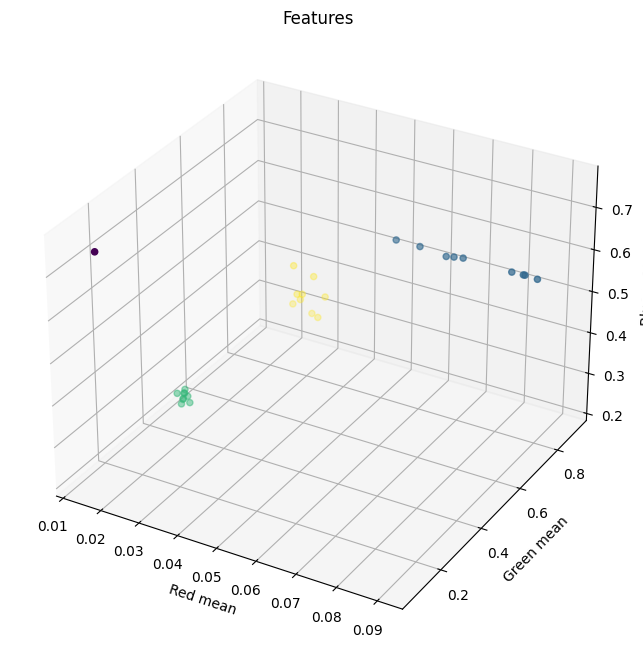

In [157]:
my_plot_3d(norm_features, labels)

Estimated number of clusters: 3
Estimated number of noise points: 1
Clustered
[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Labels
[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


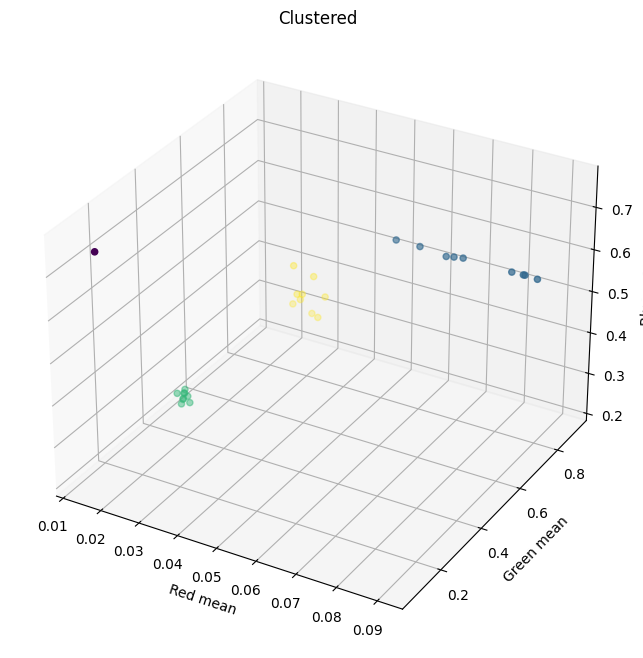

In [158]:
i0_eps = 0.08
i0_min = 9

i1_eps = 0.05
i1_min = 9

clustering = DBSCAN(eps=0.2, min_samples=i1_min).fit(norm_features)
cl = clustering.labels_

n_clusters_ = len(set(cl)) - (1 if -1 in cl else 0)
n_noise_ = list(cl).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print("Clustered")
print(cl.tolist())
print("Labels")
print(labels)
my_plot_3d(norm_features, cl, title="Clustered")

In [ ]:
# do the color stuff